# Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import numpy as np
import pandas as pd
import optuna
import seaborn as sns
import contractions
import operator
import matplotlib.pyplot as plt
from itertools import islice
%matplotlib inline

from sklearn.model_selection import train_test_split

from seqeval.metrics import f1_score
from seqeval.scheme import IOB2

from tqdm import tqdm

import spacy
nlp = spacy.load("en_core_web_sm")
from spacy.tokenizer import Tokenizer
tokenizer = Tokenizer(nlp.vocab)

# Set device = CUDA if available
if torch.cuda.is_available():
    dev = 'cuda'
elif torch.backends.mps.is_available():
    dev = 'mps'
else:
    dev = 'cpu'
device = torch.device(dev)    
print(f'Device: {device}')

Device:  cpu


# Reading CSV File into Pandas DataFrame

In [2]:
# Reading Train Dataset into DataFrame
dataF = pd.read_csv('Data/hw2_train.csv', index_col = 0)
dataF.columns = ['texts', 'tags']
print('Train Set Shape:', dataF.shape)

# Removing unequal texts and tags from train dataset
list_of_dict = []
for idx, row in dataF.iterrows():
    temp_dict = {}
    len_text = len(row['texts'].split())
    len_tag = len(row['tags'].split())
    if(len_text == len_tag):
        temp_dict['texts'] = row['texts']
        temp_dict['tags'] = row['tags']
        list_of_dict.append(temp_dict)
df = pd.DataFrame.from_dict(list_of_dict)
print('Train Set with unequal rows removed Shape: ', df.shape)

# Reading Test Dataset into DataFrame
test_data = pd.read_csv('Data/hw2_test.csv', index_col = 0)
test_data.columns = ['texts']
print('Test Set Shape:', test_data.shape)

Train Set Shape: (2312, 2)
Train Set with unequal rows removed Shape:  (2253, 2)
Test Set Shape: (981, 1)


# Splitting the Training dataset into the Training set and Validation set

In [3]:
train_data, val_data = train_test_split(df,
                                        random_state = 32, 
                                        test_size = 0.25, 
                                        shuffle = True)
print('Train Data Shape: ', train_data.shape)
print('Val Data Shape: ', val_data.shape)

Train Data Shape:  (1689, 2)
Val Data Shape:  (564, 2)


# Load Pre-Trained GloVe Word Embeddings

In [4]:
glove = pd.read_csv('Data/gloVe/glove.840B.300d.txt', sep = ' ', quoting = 3, header = None, index_col = 0)
glove_embedding = {key: val.values for key, val in glove.T.items()}
print('GloVe Embeddings Length: ', len(glove_embedding))

GloVe Embeddings Length:  2196009


# Create NumPy Array for Vocab and Emeddings

In [5]:
vocab = list(glove_embedding.keys())
embeddings = list(glove_embedding.values())

vocab = np.array(vocab)
embeddings = np.array(embeddings)
print('Vocab Shape: ', vocab.shape)
print('Embeddings Shape: ', embeddings.shape)

Vocab Shape:  (2196009,)
Embeddings Shape:  (2196009, 300)


In [6]:
# Insert '<pad>' and '<unk>' tokens at start of vocab
vocab = np.insert(vocab, 0, '<pad>')
vocab = np.insert(vocab, 1, '<unk>')
print('Vocab Shape: ', vocab.shape)

# Insert embeddings for pad and unk tokens at top of embeddings
embedding_pad = np.zeros((1, 
                          embeddings.shape[1]))
embedding_unk = np.mean(embeddings, 
                        axis = 0, 
                        keepdims = True)
embeddings = np.vstack((embedding_pad, 
                        embedding_unk, 
                        embeddings))
print('Embeddings Shape: ', embeddings.shape)

Vocab Shape:  (2196011,)
Embeddings Shape:  (2196011, 300)


In [7]:
print(vocab[:5])
print(embeddings[:5])

['<pad>' '<unk>' ',' '.' 'the']
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.22418656 -0.28881998  0.13854443 ...  0.19310581 -0.07767605
  -0.1448164 ]
 [-0.082752    0.67204    -0.14987    ... -0.1918     -0.37846
  -0.06589   ]
 [ 0.012001    0.20751    -0.12578    ...  0.13871    -0.36049
  -0.035     ]
 [ 0.27204    -0.06203    -0.1884     ...  0.13015    -0.18317
   0.1323    ]]


# Dictionary for words

In [8]:
word2idx = { term: idx for idx, term in enumerate(vocab) }
word2idx['<pad>'] = 0
word2idx['<unk>'] = 1
idx2word = { idx: word for word,idx in word2idx.items() }

# Dicitionary for tags
tag_set = set()
tag_count_dict = {}
for index, row in df.iterrows():
    temp = row['tags'].split()
    for item in temp:
        tag_set.add(item)
        if item not in tag_count_dict:
            tag_count_dict[item] = 1
        else:
            tag_count_dict[item] = tag_count_dict[item] + 1

tag2idx = { tag: idx for idx, tag in enumerate(tag_set) }
idx2tag = { idx: word for word, idx in tag2idx.items() }
print('Idx to Tag Dict: ', idx2tag)

TAG_COUNT = len(tag2idx)
print('Tag Count: ', TAG_COUNT)

Idx to Tag Dict:  {0: 'I_director', 1: 'B_subject', 2: 'B_mpaa_rating', 3: 'I_char', 4: 'B_movie', 5: 'I_release_year', 6: 'I_country', 7: 'I_person', 8: 'I_movie', 9: 'I_genre', 10: 'I-movie', 11: 'I_subject', 12: 'B_producer', 13: 'I_cast', 14: 'B_country', 15: 'B_location', 16: 'B_director', 17: 'B_char', 18: 'I_mpaa_rating', 19: 'I_producer', 20: 'B_genre', 21: 'O', 22: 'B_release_year', 23: 'B_language', 24: 'B_person', 25: 'I_language', 26: 'B_cast'}
Tag Count:  27


# Representation of Tags in the Dataset

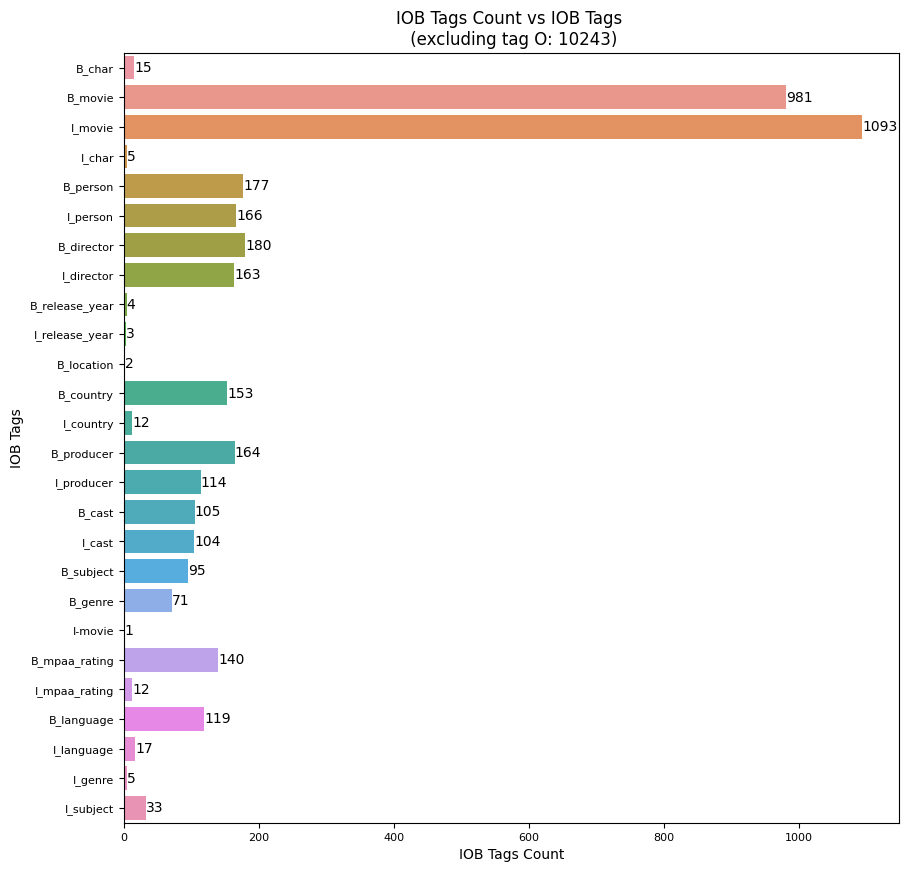

In [9]:
tag_names = list(tag_count_dict.keys())
o_tag = tag_names.pop(0)

tag_count = list(tag_count_dict.values())
o_tag_count = tag_count.pop(0)

tag_df = pd.DataFrame({"iob_tags_count": tag_count, "iob_tags": tag_names})
plt.figure(figsize = (10, 10))
splot = sns.barplot(x = "iob_tags_count", y = "iob_tags" , data = tag_df, orient ='h')
splot.bar_label(splot.containers[0], color='black')
plt.xlabel("IOB Tags Count", size = 10)
plt.ylabel("IOB Tags", size = 10)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)
plt.title("IOB Tags Count vs IOB Tags \n (excluding tag %s: %d)" %(o_tag, o_tag_count))

plt.savefig('Images/tag_count.png')

# SlotTagger Class for DataLoader

In [10]:
class SlotTaggerDataset(Dataset):
    
    def __init__(self, 
                 data: pd.DataFrame):
        self.data = data
        self.texts = self.data['texts']
        if 'tags' in self.data.columns:
            self.tags = self.data['tags']
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, 
                    idx: int):
        # Enoding Text
        text = self.texts.iloc[idx]
        encoded_text = self.encode_text(text)
        
        # Encoding Tags if they exist
        if 'tags' in self.data.columns:
            tag = self.tags.iloc[idx]
            encoded_tag = self.encode_tag(tag)
            return encoded_text, encoded_tag 
        else:
            return encoded_text
        
    # Tokenize    
    def tokenize(self, 
                 text: str):
        return [i.text for i in tokenizer(text)]
    
    # Encode Text
    def encode_text(self, 
                    text):
        text_list = [word for word in self.tokenize(text)]
        text_vector = []
        for word in text_list:
            if word in word2idx:
                text_vector.append(word2idx[word])
            else:
                text_vector.append(1)
        return text_vector
    
    # Enocde Tags
    def encode_tag(self, 
                   tag):
        tag_list = [word for word in self.tokenize(tag)]
        tag_vector = [tag2idx[word] for word in tag_list]
        return tag_vector

# Slot Tagger Object for DataLoader

In [11]:
train_ds = SlotTaggerDataset(train_data)
print(train_ds[0])
print(train_ds[1])
print(train_ds[2])
print(train_ds[11])

val_ds = SlotTaggerDataset(val_data)

test_ds = SlotTaggerDataset(test_data)

([76, 32, 9, 21273], [21, 21, 21, 4])
([452, 21926, 1918, 13505], [21, 12, 19, 19])
([177, 35300, 40721, 96, 605], [21, 16, 0, 21, 21])
([84, 40, 24358, 1584, 28, 1279], [21, 21, 4, 8, 21, 21])


# Custom Collate function

In [12]:
def custom_collate_fn(batch):
    if isinstance(batch[0], list):
        texts_tensor = [torch.tensor(text) for text in batch]

        lengths = [len(text) for text in batch]
        lengths = torch.tensor(lengths)

        texts_padded = pad_sequence(texts_tensor, batch_first = True, padding_value = 0)

        return texts_padded, lengths

    else:
        texts, tags = zip(*batch)

        texts_tensor = [torch.tensor(text) for text in texts]
        tags_tensor = [torch.tensor(tag) for tag in tags]

        lengths = [len(text) for text in texts]
        lengths = torch.tensor(lengths)

        texts_padded = pad_sequence(texts_tensor, batch_first = True, padding_value = 0)
        tags_padded = pad_sequence(tags_tensor, batch_first = True, padding_value = 0)

        return texts_padded, tags_padded, lengths

BATCH_SIZE = 32

# PyTorch Data Loaders
train_loader = DataLoader(train_ds, 
                          batch_size = BATCH_SIZE, 
                          shuffle = True, 
                          collate_fn = custom_collate_fn)
val_loader = DataLoader(val_ds, 
                        batch_size = BATCH_SIZE, 
                        shuffle = True, 
                        collate_fn = custom_collate_fn)

test_loader = DataLoader(test_ds, 
                        batch_size = 1, 
                        shuffle = False, 
                        collate_fn = custom_collate_fn)

it = iter(train_loader)
first = next(it)
second = next(it)
print(first)
print(second)

assert train_data.shape[0] == len(train_loader.dataset)
assert val_data.shape[0] == len(val_loader.dataset)
assert test_data.shape[0] == len(test_loader.dataset)

(tensor([[    177,    1022,     742,      13,   30141,    2489,       0,       0,
               0,       0,       0,       0,       0,       0,       0],
        [    605,     173,       9,   47750,       0,       0,       0,       0,
               0,       0,       0,       0,       0,       0,       0],
        [     80,      12,       4,    2511,       9,    5333,    3182,   42742,
               0,       0,       0,       0,       0,       0,       0],
        [    110,     153,       6,     115,      76,    3874,     538,   35187,
               0,       0,       0,       0,       0,       0,       0],
        [    110,     159,       6,     120,       8,     669,       9,   11020,
               0,       0,       0,       0,       0,       0,       0],
        [   2511,       7,    4680,    4679,       0,       0,       0,       0,
               0,       0,       0,       0,       0,       0,       0],
        [    452,      13,    6456,    1437,       0,       0,       0,    

# Bi-LSTM Model

In [13]:
class LSTM(nn.Module):
    
    def __init__(self, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 n_layers, 
                 bidirectional, 
                 dropout):
        super().__init__()
        # Initialize Embedding Layer with Pre-Trained Embeddings (Vector Sequences)
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embeddings).float())
        # Initialzie LSTM layer to process the vector sequences 
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout,
                            batch_first = True)
        num_directions = 2 if bidirectional else 1
        # Initialize Dense layers to predict
        self.fc1 = nn.Linear(hidden_dim * num_directions, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        # Initialize dropout to improve with regularization
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, 
                x, 
                x_lengths):
        # Embedding Layer
        embedded = self.embedding(x)
        # Dropout Layer before LSTM Layer
        embedded = self.dropout(embedded)
        # Packed Sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, 
                                                            x_lengths, 
                                                            batch_first = True, 
                                                            enforce_sorted = False)
        # LSTM Layer
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # Unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, 
                                                                  batch_first = True)
        # 1st Fully Connected Layer
        output = self.fc1(output)
        # Dropout Layer before Output
        output = self.dropout(output)
        # 2nd Fully Connected Layer
        output = self.fc2(output)
        return output

# Model Hyper-parameters

In [14]:
torch.manual_seed(32)

EMBEDDING_DIM = embeddings.shape[1]
HIDDEN_DIM = 20
OUTPUT_DIM = TAG_COUNT
NUM_LAYERS = 2
BIDIRECTION = True
DROPOUT = 0.2

model = LSTM(EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            NUM_LAYERS, 
            BIDIRECTION, 
            DROPOUT).to(device)

print('LSTM Model: ', model)

LSTM Model:  LSTM(
  (embedding): Embedding(2196011, 300)
  (lstm): LSTM(300, 20, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=40, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=27, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [15]:
def squeezed_list(my_list):
    temp_list = [int(element) for element in my_list]
    return temp_list  

def slice_list(my_list, slice_increment):
    return [my_list[i : i + slice_increment] for i in range(0, len(my_list), slice_increment)]

def convert_idx_to_tags(lol, isTensor):
    iob_list = []
    for list_element in lol:
        if (isTensor):
            list_element = list_element.numpy() 
        iob = [idx2tag[index] for index in list_element]
        iob_list.append(iob)
    return iob_list

# Model Train & Evaluate Functions

In [16]:
# Model Train Function
def train(loader, 
          model, 
          optimizer, 
          loss_fn):
    model.train()
    losses = []
    pbar = tqdm(loader)
    for x, y, lengths in pbar:
        optimizer.zero_grad()
        
        # Calculate y_pred
        y_pred = model(x, lengths)
        
        # Convert y_pred to 2D Tensor
        y_pred = y_pred.view(-1, y_pred.shape[-1])
        # Convert y_pred to 1D Tensor
        y = torch.flatten(y)
        
        loss = loss_fn(y_pred, y)
        pbar.set_postfix({'Loss': loss.item()})
        losses.append(loss.item())
        
        # Calculate gradients for w/b
        loss.backward()  
        # Update weights according to optimizer rules
        optimizer.step()          
    return round((sum(losses) / len(losses)), 4)

# Model Evaluate Function
def evaluate(loader, 
             model, 
             loss_fn, 
             score_fn):
    model.eval()
    losses = []
    for x, y, lengths in tqdm(loader):
        y_pred = model(x, lengths)
        
        max_len = x.shape[1]
              
        # Convert y_pred to 2D Tensor
        y_pred = y_pred.view(-1, y_pred.shape[-1])
        # Convert y_pred to 1D Tensor
        y = torch.flatten(y)
        
        loss = loss_fn(y_pred, y)
        losses.append(loss.item())
        
        tags_iob = convert_idx_to_tags(slice_list(y, max_len), True)

        max_preds = y_pred.argmax(dim = 1, keepdim = True) # Get the index of the max probability
        
        predictions_iob = convert_idx_to_tags(slice_list((squeezed_list(max_preds)), max_len), False)
    
    score = score_fn(tags_iob, predictions_iob, scheme = IOB2)
    return tags_iob, predictions_iob, round((sum(losses) / len(losses)), 4), round(score, 4)

# Model Training on Train dataset and Evaluation on Validation dataset

In [17]:
optimizer = torch.optim.AdamW(model.parameters(),
                              lr = 0.01)
loss_fn = nn.CrossEntropyLoss().to(device)
score_fn = f1_score

train_loss_list = []
val_loss_list = []
f1_score_list = []
n_epochs = 25
best_acc = 0
PATH = f'best-model.pt'

for epoch in range(n_epochs):
    # Model Training
    train_loss = train(train_loader, 
                     model, 
                     optimizer, 
                     loss_fn)
    train_loss_list.append(train_loss)
    print('Train Loss: ', train_loss)
    
    # Model Evaluation
    tags, predictions, val_loss, accuracy = evaluate(val_loader, 
                                                       model, 
                                                       loss_fn, 
                                                       score_fn)
    val_loss_list.append(val_loss)
    f1_score_list.append(accuracy)
    print('Val Accuracy: ', accuracy)
    print('Val Loss: ', val_loss)
    
    # Save model if Validation F1_Score is greather than 75%
    if accuracy > best_acc and accuracy > 0.75:
        torch.save(model.state_dict(), PATH)

100%|███████████████████████████████| 53/53 [00:00<00:00, 83.47it/s, Loss=0.423]


Train Loss:  1.2709


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 219.54it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_movie seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_movie seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_director seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_producer seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/

Val Accuracy:  0.5714
Val Loss:  0.3958


100%|██████████████████████████████| 53/53 [00:00<00:00, 103.91it/s, Loss=0.172]


Train Loss:  0.3286


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 209.74it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_person seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_person seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_subject seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_char seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Val Accuracy:  0.575
Val Loss:  0.2679


100%|████████████████████████████████| 53/53 [00:00<00:00, 109.02it/s, Loss=0.2]


Train Loss:  0.2299


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 265.13it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_mpaa_rating seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Val Accuracy:  0.7568
Val Loss:  0.1921


100%|██████████████████████████████| 53/53 [00:00<00:00, 105.17it/s, Loss=0.102]


Train Loss:  0.1632


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 257.49it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_cast seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_cast seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Val Accuracy:  0.7529
Val Loss:  0.1721


100%|██████████████████████████████| 53/53 [00:00<00:00, 104.21it/s, Loss=0.135]


Train Loss:  0.1335


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 252.01it/s]


Val Accuracy:  0.9114
Val Loss:  0.148


100%|███████████████████████████████| 53/53 [00:00<00:00, 97.15it/s, Loss=0.103]


Train Loss:  0.1133


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 242.18it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_char seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Val Accuracy:  0.7619
Val Loss:  0.1329


100%|█████████████████████████████| 53/53 [00:00<00:00, 108.68it/s, Loss=0.0425]


Train Loss:  0.0887


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 256.97it/s]


Val Accuracy:  0.825
Val Loss:  0.1246


100%|█████████████████████████████| 53/53 [00:00<00:00, 109.54it/s, Loss=0.0613]


Train Loss:  0.0705


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 261.29it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_country seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Val Accuracy:  0.7436
Val Loss:  0.1109


100%|██████████████████████████████| 53/53 [00:00<00:00, 110.99it/s, Loss=0.125]


Train Loss:  0.0681


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 254.74it/s]


Val Accuracy:  0.9211
Val Loss:  0.121


100%|█████████████████████████████| 53/53 [00:00<00:00, 102.29it/s, Loss=0.0497]


Train Loss:  0.06


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 259.96it/s]


Val Accuracy:  0.9867
Val Loss:  0.1154


100%|█████████████████████████████| 53/53 [00:00<00:00, 105.78it/s, Loss=0.0429]


Train Loss:  0.055


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 258.78it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_language seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Val Accuracy:  0.9873
Val Loss:  0.1289


100%|█████████████████████████████| 53/53 [00:00<00:00, 105.77it/s, Loss=0.0569]


Train Loss:  0.0454


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 257.78it/s]


Val Accuracy:  0.8947
Val Loss:  0.1314


100%|█████████████████████████████| 53/53 [00:00<00:00, 105.09it/s, Loss=0.0178]


Train Loss:  0.0407


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 251.97it/s]


Val Accuracy:  0.9744
Val Loss:  0.1224


100%|██████████████████████████████| 53/53 [00:00<00:00, 102.97it/s, Loss=0.077]


Train Loss:  0.0404


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 253.90it/s]


Val Accuracy:  0.9211
Val Loss:  0.1173


100%|█████████████████████████████| 53/53 [00:00<00:00, 105.25it/s, Loss=0.0374]


Train Loss:  0.0376


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 237.90it/s]


Val Accuracy:  0.9459
Val Loss:  0.1033


100%|██████████████████████████████| 53/53 [00:00<00:00, 104.62it/s, Loss=0.072]


Train Loss:  0.0369


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 244.76it/s]


Val Accuracy:  0.9333
Val Loss:  0.119


100%|█████████████████████████████| 53/53 [00:00<00:00, 105.62it/s, Loss=0.0234]


Train Loss:  0.0297


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 260.41it/s]


Val Accuracy:  0.8831
Val Loss:  0.1161


100%|████████████████████████████| 53/53 [00:00<00:00, 102.38it/s, Loss=0.00817]


Train Loss:  0.033


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 245.40it/s]


Val Accuracy:  0.875
Val Loss:  0.1061


100%|██████████████████████████████| 53/53 [00:00<00:00, 94.98it/s, Loss=0.0294]


Train Loss:  0.0291


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 236.41it/s]


Val Accuracy:  0.8889
Val Loss:  0.1049


100%|██████████████████████████████| 53/53 [00:00<00:00, 97.06it/s, Loss=0.0164]


Train Loss:  0.0226


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 236.94it/s]


Val Accuracy:  0.9867
Val Loss:  0.1157


100%|██████████████████████████████| 53/53 [00:00<00:00, 99.93it/s, Loss=0.0284]


Train Loss:  0.0223


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 245.00it/s]


Val Accuracy:  0.9351
Val Loss:  0.117


100%|█████████████████████████████| 53/53 [00:00<00:00, 100.25it/s, Loss=0.0597]


Train Loss:  0.027


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 232.34it/s]


Val Accuracy:  0.8923
Val Loss:  0.118


100%|█████████████████████████████| 53/53 [00:00<00:00, 99.01it/s, Loss=0.00615]


Train Loss:  0.0219


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 248.50it/s]
/Users/kushagraseth/Documents/pvenv/lib/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: I_genre seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Val Accuracy:  0.9383
Val Loss:  0.1232


100%|██████████████████████████████| 53/53 [00:00<00:00, 99.33it/s, Loss=0.0444]


Train Loss:  0.0232


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 251.81it/s]


Val Accuracy:  0.962
Val Loss:  0.1267


100%|█████████████████████████████| 53/53 [00:00<00:00, 99.82it/s, Loss=0.00781]


Train Loss:  0.0268


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 241.66it/s]


Val Accuracy:  0.8857
Val Loss:  0.1206


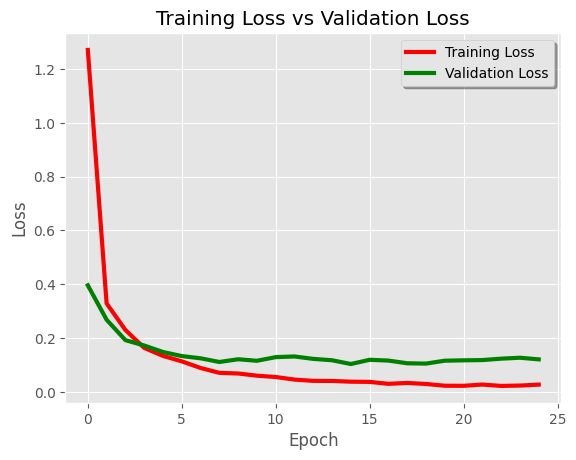

In [18]:
epochs = np.arange(n_epochs)  

plt.style.use('ggplot')
plt.plot(epochs, train_loss_list, label = "Training Loss", color = "red", linewidth = '3')
plt.plot(epochs, val_loss_list, label = "Validation Loss", color = "green", linewidth = '3')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Validation Loss', color = 'black')
plt.legend(shadow = True, labelcolor = 'black')
plt.savefig('Images/train_vs_val_loss_plot.png')

# Validation Accuracy Plot

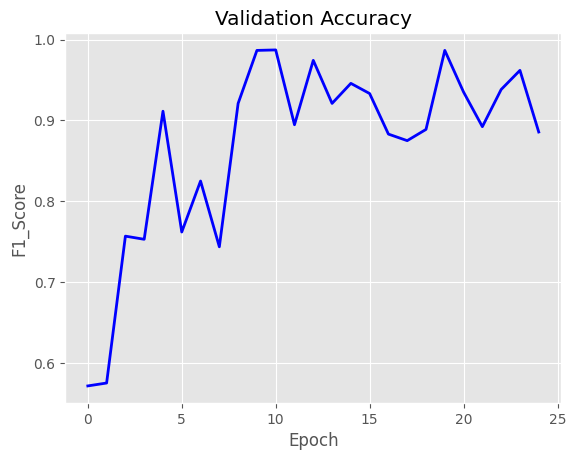

In [19]:
plt.plot(epochs, f1_score_list, color = 'blue', linewidth = '2')
plt.xlabel('Epoch')
plt.ylabel('F1_Score')
plt.title('Validation Accuracy', color = 'black')
plt.savefig('Images/f1_accuracy_plot.png')

# Load the saved model

In [20]:
saved_model = LSTM(EMBEDDING_DIM, 
                   HIDDEN_DIM, 
                   OUTPUT_DIM, 
                   NUM_LAYERS, 
                   BIDIRECTION, 
                   DROPOUT).to(device)

saved_model.load_state_dict(torch.load(PATH))
saved_model.eval()

LSTM(
  (embedding): Embedding(2196011, 300)
  (lstm): LSTM(300, 20, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=40, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=27, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

# Model Predict Function

In [21]:
def predict(loader, 
            model):
    predictions = []
    for x, lengths in tqdm(loader):
        with torch.no_grad():
            y_pred = saved_model.forward(x, lengths)
            
            max_len = x.shape[1]

            # Convert y_pred to 2D Tensor
            y_pred = y_pred.view(-1, y_pred.shape[-1])

            max_preds = y_pred.argmax(dim = 1, keepdim = True) # Get the index of the max probability
            predictions_iob = convert_idx_to_tags(slice_list((squeezed_list(max_preds)), max_len), False)
            predictions.append(predictions_iob)
    
    return predictions

predicted_tags = predict(test_loader, saved_model)
predicted_tags = np.array(predicted_tags)
predicted_tags = predicted_tags.squeeze().tolist()

100%|███████████████████████████████████████| 981/981 [00:00<00:00, 1706.05it/s]
/var/folders/hk/l7897jp170bb9tbb20n80tz00000gn/T/ipykernel_93210/242441740.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predicted_tags = np.array(predicted_tags)


# Creating Dictionary of Predictions

In [22]:
list_of_dict = []
for i in range(len(predicted_tags)):
    temp_dict = {}
    temp_dict["ID"] = i
    temp_dict["IOB Slot tags"] = ' '.join(predicted_tags[i])
    list_of_dict.append(temp_dict)

# Converting Dictionary to CSV and compress it for submission to CodaLab
tags_df = pd.DataFrame.from_dict(list_of_dict)
tags_df.to_csv('submission.csv.zip', compression = 'zip', index = False)
print(tags_df)

      ID                                      IOB Slot tags
0      0                                        O O B_movie
1      1                          O O O O O B_movie I_movie
2      2                        O O O O O O B_movie I_movie
3      3                                      O O O B_movie
4      4                                      O O O B_movie
..   ...                                                ...
976  976        O O B_movie I_movie I_movie I_movie I_movie
977  977                            O B_movie I_movie O O O
978  978                O O O O O O B_producer I_producer O
979  979  O O B_director I_director O O O O B_movie I_mo...
980  980                   O O B_director O O O O B_country

[981 rows x 2 columns]
